In [1]:
import h5py 
import photocurrent_sim
import numpy as np
import jax.random as jrand
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from circuitmap import NeuralDemixer

import sys
sys.path.append('../')
import nmu
import subtractr
import grid_utils as util
import subtract_utils
from subtract_utils import traces_tensor_to_map

In [48]:
# load dataset
dataset_path = '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell2_opsPositive_A_planes_cmReformat.mat'
with h5py.File(dataset_path) as f:
        pscs = np.array(f['pscs']).T
        stim_mat = np.array(f['stimulus_matrix']).T
        targets = np.array(f['targets']).T
        powers = np.max(stim_mat, axis=0)

# generate basis of photocurrent shapes using simulator
key = jrand.PRNGKey(0)
prev_shape, curr_shapes, next_shapes = photocurrent_sim.sample_photocurrent_shapes(
    key, 
    500, 
    onset_jitter_ms=1.0,
)

In [57]:
# Run PCA to get subspace of shapes
pscs = pscs[:, 0:750]
curr_shapes = curr_shapes[:, 0:750]

n_components = 30
pca = PCA(n_components=n_components)
pca.fit(curr_shapes)
projected = pca.inverse_transform(pca.transform(pscs))

# Run rank-1 decomp
# init_factors = [(x[0], y[])
# factors = nmu.recursive_nmu(pscs,
#             r=10, init_factors=init_factors,
#             update_u=False, update_v=True)
# U, S, V = np.linalg.svd(projected)


In [81]:
projected.shape

(33801, 750)

In [88]:

rank = 2
# est = U[:,0:rank] * S[0:rank] @ V[0:rank,:]

est = subtractr.estimate_photocurrents(
    projected,
    powers,
    stepwise=True,
    rank=rank,
    separate_by_power=False,
)

# est = projected

In [92]:
subtracted = pscs - est

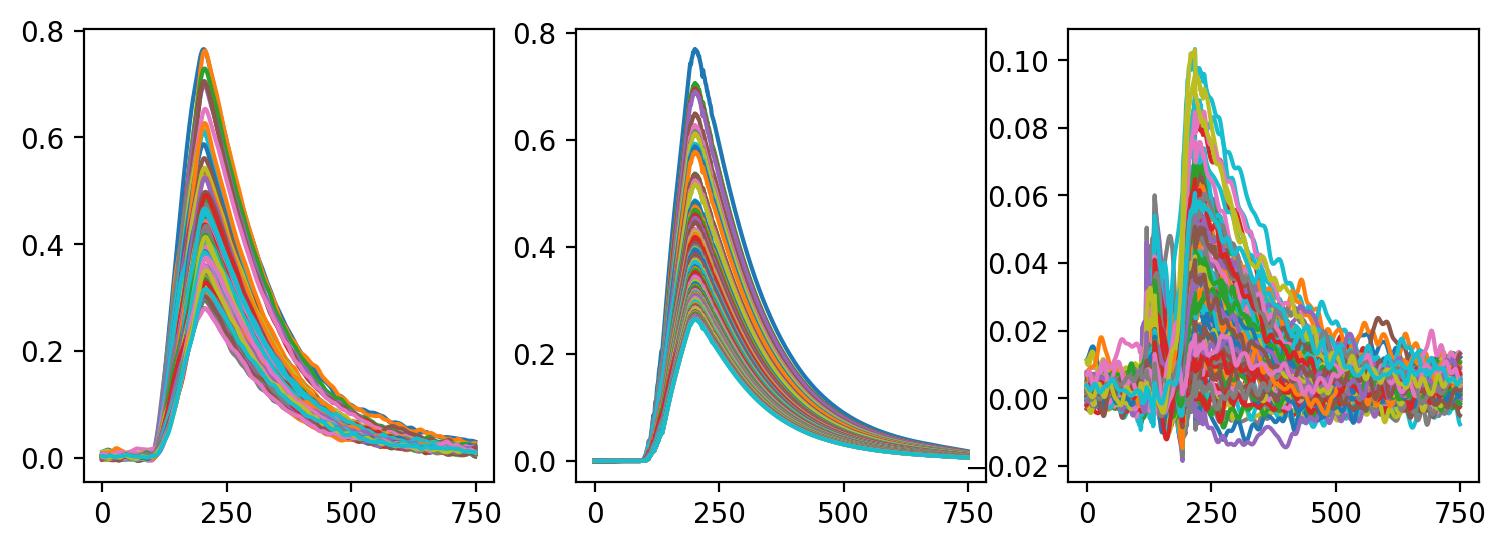

In [95]:
fig, axs = plt.subplots(nrows=1, ncols = 3, figsize=(9,3), dpi=200)
ys = np.sum(est, axis=-1)
idxs = np.argsort(ys)[::-1]

plot_step = 1
num_to_plot=100
axs[0].plot(pscs[idxs[0:num_to_plot*plot_step:plot_step]].T)
axs[1].plot(est[idxs[0:num_to_plot*plot_step:plot_step]].T)
axs[2].plot(subtracted[idxs[0:num_to_plot*plot_step:plot_step]].T)

